In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Veriyi yükleme
df = pd.read_csv('usacc.csv')

# 1M örneklem alma
df_sample = df.sample(n=2000000, random_state=42)

print("Örneklem boyutu:", df_sample.shape)

Örneklem boyutu: (1000000, 46)


In [24]:
# Özellik seçimi
trafik_ozellikleri = [
    'Traffic_Signal', 'Stop', 'Give_Way', 'Traffic_Calming', 
    'Roundabout', 'Crossing', 'Junction'
]

tarih_saat_ozellikleri = [
    'Start_Time', 'End_Time'
]

# Yeni özellikler için gerekli sütunlar
yol_ozellikleri = ['Junction']  # Junction zaten var

# Hedef değişken
hedef_degisken = 'Severity'

# Seçilen özelliklerle yeni dataframe oluşturma
selected_features = trafik_ozellikleri + tarih_saat_ozellikleri + [hedef_degisken]
df_selected = df_sample[selected_features].copy()

print(f"\nSeçilen özellikler: {selected_features}")
print(f"Yeni veri seti boyutu: {df_selected.shape}")


Seçilen özellikler: ['Traffic_Signal', 'Stop', 'Give_Way', 'Traffic_Calming', 'Roundabout', 'Crossing', 'Junction', 'Start_Time', 'End_Time', 'Severity']
Yeni veri seti boyutu: (1000000, 10)


In [25]:
# Eksik veri kontrolü ve temizleme
print("\nEksik veri yüzdeleri:")
missing_percent = (df_selected.isnull().sum() / len(df_selected)) * 100
print(missing_percent.sort_values(ascending=False))


Eksik veri yüzdeleri:
Traffic_Signal     0.0
Stop               0.0
Give_Way           0.0
Traffic_Calming    0.0
Roundabout         0.0
Crossing           0.0
Junction           0.0
Start_Time         0.0
End_Time           0.0
Severity           0.0
dtype: float64


In [26]:
# Tarih/saat dönüşümü
df_selected['Start_Time'] = pd.to_datetime(df_selected['Start_Time'], errors='coerce')
df_selected['End_Time'] = pd.to_datetime(df_selected['End_Time'], errors='coerce')

# Tarih/saat özelliklerini çıkarma
df_selected['Hour'] = df_selected['Start_Time'].dt.hour
df_selected['DayOfWeek'] = df_selected['Start_Time'].dt.dayofweek  # 0: Pazartesi, 6: Pazar
df_selected['Month'] = df_selected['Start_Time'].dt.month
df_selected['Year'] = df_selected['Start_Time'].dt.year

# Kaza süresi hesaplama (dakika cinsinden)
df_selected['Duration_minutes'] = (df_selected['End_Time'] - df_selected['Start_Time']).dt.total_seconds() / 60

print("Tarih/saat özellikleri başarıyla eklendi!")

Tarih/saat özellikleri başarıyla eklendi!


In [27]:
# is_high_energy_zone özelliğini oluşturma
# Not: Dataset'te road_type olmadığı için sadece Junction=True kullanıyoruz
# Gerçek uygulamada road_type da olmalı
print("Yeni özellikler oluşturuluyor...")

# is_high_energy_zone: Junction=True olan bölgeler
df_selected['is_high_energy_zone'] = df_selected['Junction']

# Ek trafik yoğunluk göstergeleri
df_selected['has_traffic_control'] = df_selected['Traffic_Signal'] | df_selected['Stop'] | df_selected['Give_Way']
df_selected['complex_intersection'] = df_selected['Junction'] & df_selected['Crossing']

print("Yeni özellikler oluşturuldu:")
print(f"- is_high_energy_zone: {df_selected['is_high_energy_zone'].sum()} kaza")
print(f"- has_traffic_control: {df_selected['has_traffic_control'].sum()} kaza") 
print(f"- complex_intersection: {df_selected['complex_intersection'].sum()} kaza")

Yeni özellikler oluşturuluyor...
Yeni özellikler oluşturuldu:
- is_high_energy_zone: 73669 kaza
- has_traffic_control: 175815 kaza
- complex_intersection: 1061 kaza


In [28]:
# Trafik özelliklerinin özet istatistikleri
print("\nTrafik özelliklerinin özeti:")
tum_trafik_ozellikleri = trafik_ozellikleri + ['is_high_energy_zone', 'has_traffic_control', 'complex_intersection']
trafik_ozet = df_selected[tum_trafik_ozellikleri].sum().sort_values(ascending=False)
print(trafik_ozet)


Trafik özelliklerinin özeti:
has_traffic_control     175815
Traffic_Signal          147680
Crossing                112449
Junction                 73669
is_high_energy_zone      73669
Stop                     27489
Give_Way                  4761
complex_intersection      1061
Traffic_Calming            964
Roundabout                  34
dtype: int64


In [29]:
# Severity dağılımı ve 0'dan başlayacak şekilde düzenleme
print(f"\nOrijinal Severity dağılımı:")
print(df_selected[hedef_degisken].value_counts().sort_index())

# Severity değerlerini 0'dan başlat (1->0, 2->1, 3->2, 4->3)
df_selected[hedef_degisken] = df_selected[hedef_degisken] - 1

print(f"\nDüzenlenmiş Severity dağılımı:")
print(df_selected[hedef_degisken].value_counts().sort_index())


Orijinal Severity dağılımı:
Severity
1      8785
2    796174
3    168475
4     26566
Name: count, dtype: int64

Düzenlenmiş Severity dağılımı:
Severity
0      8785
1    796174
2    168475
3     26566
Name: count, dtype: int64


In [30]:
# Model için feature engineering
model_features = tum_trafik_ozellikleri + ['Hour', 'DayOfWeek', 'Month', 'Year', 'Duration_minutes']

print(f"Modelde kullanılacak özellikler ({len(model_features)} adet):")
for feature in model_features:
    print(f"  - {feature}")

# Eksik verileri temizleme
df_model = df_selected[model_features + [hedef_degisken]].copy()
df_model = df_model.dropna()

print(f"\nModel için kullanılacak veri boyutu: {df_model.shape}")

# Bağımsız değişkenler (X) ve hedef değişken (y)
X = df_model[model_features]
y = df_model[hedef_degisken]

# Sınıf sayısını belirle
num_classes = len(y.unique())
print(f"\nSınıf sayısı: {num_classes}")
print(f"Sınıflar: {sorted(y.unique())}")

Modelde kullanılacak özellikler (15 adet):
  - Traffic_Signal
  - Stop
  - Give_Way
  - Traffic_Calming
  - Roundabout
  - Crossing
  - Junction
  - is_high_energy_zone
  - has_traffic_control
  - complex_intersection
  - Hour
  - DayOfWeek
  - Month
  - Year
  - Duration_minutes

Model için kullanılacak veri boyutu: (903984, 16)

Sınıf sayısı: 4
Sınıflar: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [31]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")


Eğitim seti boyutu: (723187, 15)
Test seti boyutu: (180797, 15)


In [32]:
# XGBoost modeli oluşturma ve eğitme
print("\nXGBoost modeli eğitiliyor...")

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

print("Model eğitimi tamamlandı!")


XGBoost modeli eğitiliyor...
Model eğitimi tamamlandı!


In [33]:
# Tahminler
y_pred = model.predict(X_test)

# Model değerlendirme
print("\n" + "="*50)
print("MODEL DEĞERLENDİRME SONUÇLARI")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.4f}")

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=[f"Severity_{i+1}" for i in range(num_classes)]))

print("\nKarmaşıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))


MODEL DEĞERLENDİRME SONUÇLARI
Model Doğruluğu: 0.7954

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Severity_1       0.68      0.14      0.23      1757
  Severity_2       0.82      0.95      0.88    140567
  Severity_3       0.58      0.29      0.38     33694
  Severity_4       0.47      0.06      0.10      4779

    accuracy                           0.80    180797
   macro avg       0.63      0.36      0.40    180797
weighted avg       0.76      0.80      0.76    180797


Karmaşıklık Matrisi:
[[   241   1464     51      1]
 [    87 133567   6750    163]
 [    27  23788   9732    147]
 [     1   4164    343    271]]


In [34]:
# Özellik önemlilikleri
print("\nÖzellik Önemlilikleri:")
feature_importance = pd.DataFrame({
    'feature': model_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)


Özellik Önemlilikleri:
                 feature  importance
8    has_traffic_control    0.438313
14      Duration_minutes    0.130439
13                  Year    0.123065
5               Crossing    0.115006
12                 Month    0.046046
11             DayOfWeek    0.035860
6               Junction    0.029570
1                   Stop    0.022269
10                  Hour    0.021440
0         Traffic_Signal    0.015165
3        Traffic_Calming    0.013494
2               Give_Way    0.006414
9   complex_intersection    0.002920
4             Roundabout    0.000000
7    is_high_energy_zone    0.000000


In [35]:
# Detaylı analiz
print("\n" + "="*50)
print("DETAYLI ANALİZ")
print("="*50)

# Yeni özelliklerin severity ile ilişkisi
yeni_ozellikler = ['is_high_energy_zone', 'has_traffic_control', 'complex_intersection']
print("\nYeni özelliklere göre ortalama severity (1-4 skalasında):")
for feature in yeni_ozellikler:
    avg_severity = df_model.groupby(feature)[hedef_degisken].mean() + 1
    print(f"{feature}:")
    print(avg_severity)

# Trafik özelliklerinin severity ile ilişkisi (orijinal değerlerle)
print("\nTüm trafik özelliklerine göre ortalama severity (1-4 skalasında):")
for feature in tum_trafik_ozellikleri:
    avg_severity = df_model.groupby(feature)[hedef_degisken].mean() + 1
    print(f"{feature}:")
    print(avg_severity)


DETAYLI ANALİZ

Yeni özelliklere göre ortalama severity (1-4 skalasında):
is_high_energy_zone:
is_high_energy_zone
False    2.222307
True     2.319325
Name: Severity, dtype: float64
has_traffic_control:
has_traffic_control
False    2.260795
True     2.090490
Name: Severity, dtype: float64
complex_intersection:
complex_intersection
False    2.229395
True     2.342296
Name: Severity, dtype: float64

Tüm trafik özelliklerine göre ortalama severity (1-4 skalasında):
Traffic_Signal:
Traffic_Signal
False    2.255058
True     2.090670
Name: Severity, dtype: float64
Stop:
Stop
False    2.233787
True     2.079278
Name: Severity, dtype: float64
Give_Way:
Give_Way
False    2.229720
True     2.188481
Name: Severity, dtype: float64
Traffic_Calming:
Traffic_Calming
False    2.229619
True     2.121951
Name: Severity, dtype: float64
Roundabout:
Roundabout
False    2.229518
True     2.166667
Name: Severity, dtype: float64
Crossing:
Crossing
False    2.250627
True     2.067274
Name: Severity, dtype: fl

In [36]:
# Trafik özellik kombinasyonları ve severity
print("\nÖnemli trafik özellik kombinasyonları (1-4 skalasında):")
significant_combinations = []

tum_ozellikler_kombinasyon = tum_trafik_ozellikleri + yeni_ozellikler

for i in range(len(tum_ozellikler_kombinasyon)):
    for j in range(i+1, len(tum_ozellikler_kombinasyon)):
        feature1 = tum_ozellikler_kombinasyon[i]
        feature2 = tum_ozellikler_kombinasyon[j]
        
        combination_data = df_model[(df_model[feature1] == True) & (df_model[feature2] == True)]
        if len(combination_data) > 100:  # Yeterli veri olan kombinasyonlar
            avg_severity = combination_data[hedef_degisken].mean() + 1
            count = len(combination_data)
            significant_combinations.append({
                'combination': f"{feature1} + {feature2}",
                'count': count,
                'avg_severity': avg_severity
            })

# Ortalama severity'ye göre sıralama
significant_combinations.sort(key=lambda x: x['avg_severity'], reverse=True)

print("En yüksek severity'ye sahip 10 kombinasyon:")
for combo in significant_combinations[:10]:
    print(f"{combo['combination']}: {combo['count']} kaza, Ort. Severity: {combo['avg_severity']:.2f}")


Önemli trafik özellik kombinasyonları (1-4 skalasında):
En yüksek severity'ye sahip 10 kombinasyon:
has_traffic_control + complex_intersection: 571 kaza, Ort. Severity: 2.38
has_traffic_control + complex_intersection: 571 kaza, Ort. Severity: 2.38
complex_intersection + has_traffic_control: 571 kaza, Ort. Severity: 2.38
has_traffic_control + complex_intersection: 571 kaza, Ort. Severity: 2.38
Traffic_Signal + complex_intersection: 478 kaza, Ort. Severity: 2.37
Traffic_Signal + complex_intersection: 478 kaza, Ort. Severity: 2.37
Traffic_Signal + Junction: 1097 kaza, Ort. Severity: 2.36
Traffic_Signal + is_high_energy_zone: 1097 kaza, Ort. Severity: 2.36
Traffic_Signal + is_high_energy_zone: 1097 kaza, Ort. Severity: 2.36
Crossing + Junction: 967 kaza, Ort. Severity: 2.34


In [37]:
# Özet rapor
print("\n" + "="*50)
print("ÖZET RAPOR")
print("="*50)
print(f"Toplam kaza sayısı: {len(df_model)}")
print(f"Severity dağılımı (1-4): {dict((df_model[hedef_degisken] + 1).value_counts().sort_index())}")
print(f"Model doğruluğu: {accuracy:.4f}")
print(f"En önemli 3 özellik: {list(feature_importance['feature'].head(3))}")
print(f"High energy zone kazaları: {df_model['is_high_energy_zone'].sum()} ({df_model['is_high_energy_zone'].mean()*100:.1f}%)")
print(f"Trafik kontrolü olan kazalar: {df_model['has_traffic_control'].sum()} ({df_model['has_traffic_control'].mean()*100:.1f}%)")
print(f"Karmaşık kavşak kazaları: {df_model['complex_intersection'].sum()} ({df_model['complex_intersection'].mean()*100:.1f}%)")
print(f"Ortalama kaza süresi: {df_model['Duration_minutes'].mean():.1f} dakika")


ÖZET RAPOR
Toplam kaza sayısı: 903984
Severity dağılımı (1-4): {1: np.int64(8785), 2: np.int64(702833), 3: np.int64(168468), 4: np.int64(23898)}
Model doğruluğu: 0.7954
En önemli 3 özellik: ['has_traffic_control', 'Duration_minutes', 'Year']
High energy zone kazaları: 67176 (7.4%)
Trafik kontrolü olan kazalar: 166029 (18.4%)
Karmaşık kavşak kazaları: 967 (0.1%)
Ortalama kaza süresi: 465.9 dakika


AŞAMA 1: VERİ YÜKLEME VE İLK BAKIŞ
Veri seti başarıyla yüklendi.

Örneklem boyutu: (2500000, 46)

AŞAMA 2: KEŞİFÇİ VERİ ANALİZİ (EDA)


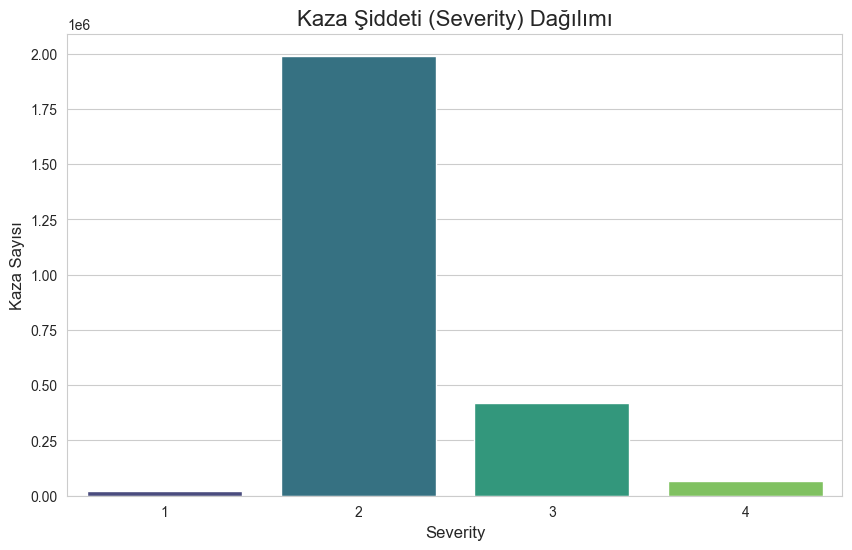


'Severity' dağılımı oldukça dengesiz. Sınıf 2 en baskın sınıftır.
Bu durum, modelleme aşamasında SMOTE gibi tekniklerin kullanılmasını gerektirir.

AŞAMA 3: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ (DÜZELTİLMİŞ)

Eksik veriler temizleniyor...

Özellik mühendisliği uygulanıyor...
Zaman ve etkileşim özellikleri oluşturuldu.
Kategorik özelliklere One-Hot Encoding uygulandı.

Tüm işlemlerden sonra son temizlenmiş veri boyutu: (2054654, 33)

Modelleme için 'Severity' hedef değişkeni 0, 1, 2, 3 olarak yeniden düzenlendi.

AŞAMA 4: MODELLEME İÇİN VERİ HAZIRLIĞI
Eğitim seti boyutu: (1643723, 32), Test seti boyutu: (410931, 32)

AŞAMA 5: SINIF DENGESİZLİĞİ GİDERME (SMOTE)
SMOTE öncesi eğitim verisi sınıf dağılımı:
 Severity
1    1290795
2     294455
3      41546
0      16927
Name: count, dtype: int64

SMOTE sonrası eğitim verisi sınıf dağılımı:
 Severity
1    1290795
2    1290795
3    1290795
0    1290795
Name: count, dtype: int64

SMOTE, sadece eğitim verisine uygulanarak veri sızıntısı önlendi

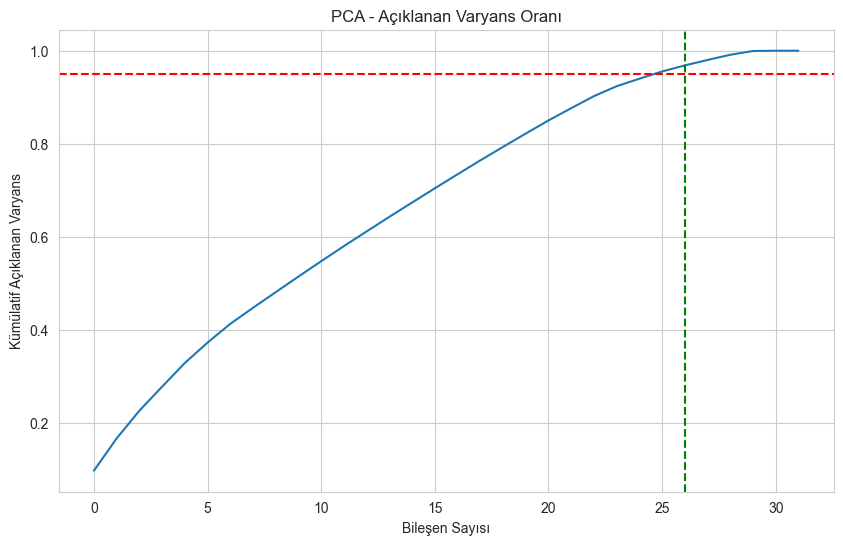


AŞAMA 7: MODELLEME

--- 7.1. Baseline Model (Dummy Classifier) ---
Baseline Model Doğruluğu: 0.0103

--- 7.2. Aday Model: Lojistik Regresyon (GridSearchCV ile) ---
Hiper-parametre optimizasyonu başlatılıyor...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

En iyi parametreler: {'C': 1.0}

AŞAMA 8: MODEL DEĞERLENDİRME
Lojistik Regresyon Modelinin Test Verisi Doğruluğu: 0.3794
Baseline Model Doğruluğu: 0.0103

Sınıflandırma Raporu (Classification Report):
              precision    recall  f1-score   support

  Severity 1       0.04      0.52      0.07      4232
  Severity 2       0.83      0.35      0.50    322699
  Severity 3       0.29      0.50      0.36     73614
  Severity 4       0.04      0.29      0.06     10386

    accuracy                           0.38    410931
   macro avg       0.30      0.42      0.25    410931
weighted avg       0.71      0.38      0.46    410931


Karmaşıklık Matrisi (Confusion Matrix):


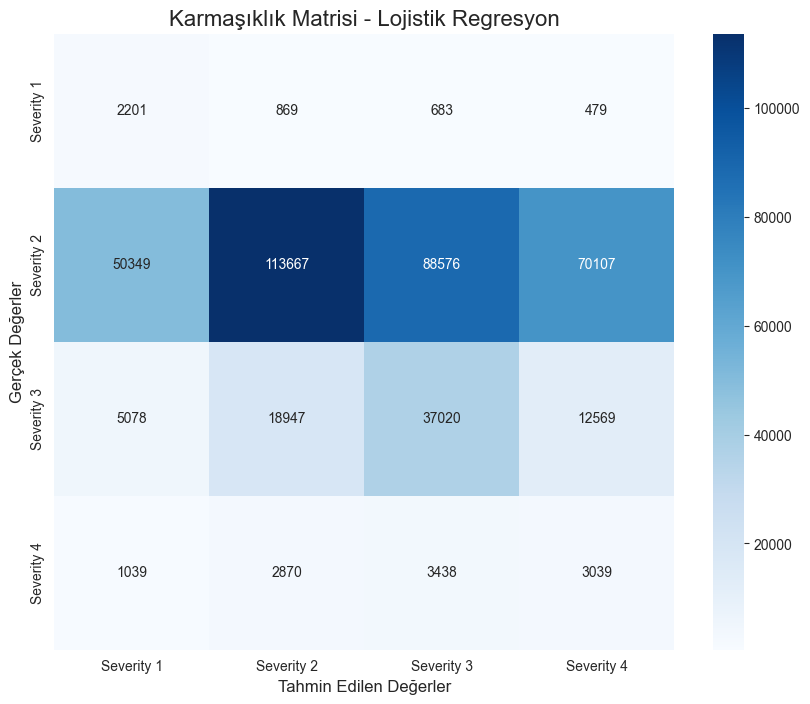


AŞAMA 9: ÖZELLİK ÖNEMLİLİKLERİ (LOJİSTİK REGRESYON KATSAYILARI)
Yorumlanabilirlik için PCA *kullanılmadan*, SMOTE uygulanmış veri üzerinde model tekrar eğitiliyor...


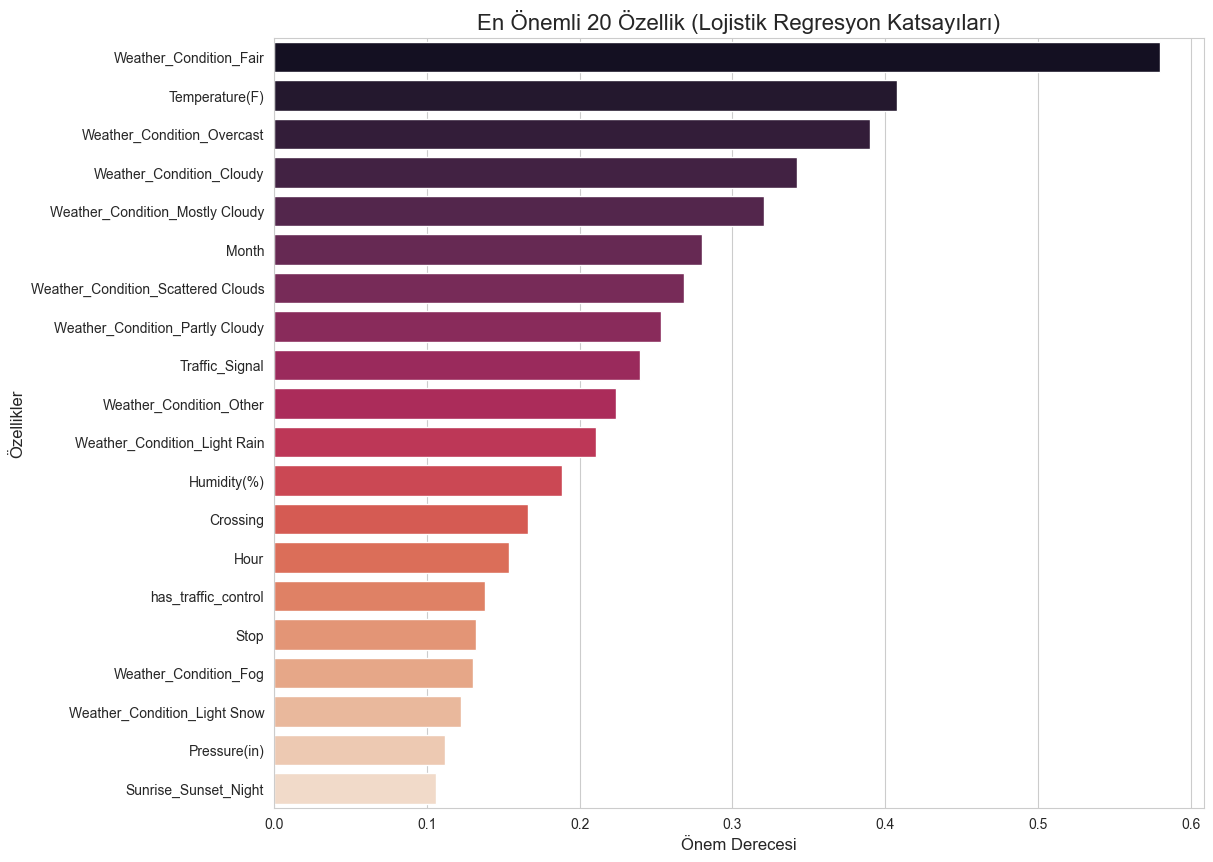


En önemli 10 özellik:
                               feature  importance
23              Weather_Condition_Fair    0.579527
10                      Temperature(F)    0.408002
29          Weather_Condition_Overcast    0.390050
22            Weather_Condition_Cloudy    0.342525
27     Weather_Condition_Mostly Cloudy    0.320615
17                               Month    0.280110
31  Weather_Condition_Scattered Clouds    0.268642
30     Weather_Condition_Partly Cloudy    0.253031
0                       Traffic_Signal    0.239607
28             Weather_Condition_Other    0.224089


In [1]:
# Gerekli Kütüphanelerin Yüklenmesi
# Bu kütüphaneleri yüklemek için: pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn kütüphaneleri
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier

# Sınıf dengesizliği için
from imblearn.over_sampling import SMOTE

# Ayarlar
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# ==============================================================================
# 1. VERİ YÜKLEME VE İLK BAKIŞ
# ==============================================================================
print("="*50)
print("AŞAMA 1: VERİ YÜKLEME VE İLK BAKIŞ")
print("="*50)

try:
    df = pd.read_csv('US_Accidents_March23.csv')
    print("Veri seti başarıyla yüklendi.")
except FileNotFoundError:
    print("HATA: 'usacc.csv' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()

# Veri setinin çok büyük olması nedeniyle daha hızlı çalışmak için 1M örneklem alıyoruz
df_sample = df.sample(n=2500000, random_state=42)

print(f"\nÖrneklem boyutu: {df_sample.shape}")

# ==============================================================================
# 2. KEŞİFÇİ VERİ ANALİZİ (EDA)
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 2: KEŞİFÇİ VERİ ANALİZİ (EDA)")
print("="*50)

# Hedef Değişken 'Severity' Dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x='Severity', data=df_sample, palette='viridis')
plt.title('Kaza Şiddeti (Severity) Dağılımı', fontsize=16)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Kaza Sayısı', fontsize=12)
plt.show()

print("\n'Severity' dağılımı oldukça dengesiz. Sınıf 2 en baskın sınıftır.")
print("Bu durum, modelleme aşamasında SMOTE gibi tekniklerin kullanılmasını gerektirir.")

# ==============================================================================
# 3. VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ (DÜZELTİLMİŞ)
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 3: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ (DÜZELTİLMİŞ)")
print("="*50)

selected_features = [
    'Severity', 'Start_Time',
    'Traffic_Signal', 'Stop', 'Give_Way', 'Traffic_Calming',
    'Roundabout', 'Crossing', 'Junction', 'Amenity', 'Bump', 'Railway',
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
    'Sunrise_Sunset', 'Weather_Condition'
]
df_processed = df_sample[selected_features].copy()

# --- Eksik Veri İşleme (Adım 1: İlk Temizlik) ---
print("\nEksik veriler temizleniyor...")
df_processed = df_processed.drop('Wind_Chill(F)', axis=1)
df_processed.dropna(inplace=True)

# --- Özellik Mühendisliği ---
print("\nÖzellik mühendisliği uygulanıyor...")
df_processed['Start_Time'] = pd.to_datetime(df_processed['Start_Time'], errors='coerce')

df_processed['Hour'] = df_processed['Start_Time'].dt.hour
df_processed['DayOfWeek'] = df_processed['Start_Time'].dt.dayofweek
df_processed['Month'] = df_processed['Start_Time'].dt.month
df_processed = df_processed.drop(['Start_Time'], axis=1)

df_processed['is_high_energy_zone'] = df_processed['Junction']
df_processed['has_traffic_control'] = df_processed['Traffic_Signal'] | df_processed['Stop'] | df_processed['Give_Way']
df_processed['complex_intersection'] = df_processed['Junction'] & df_processed['Crossing']
print("Zaman ve etkileşim özellikleri oluşturuldu.")

# --- Kategorik Veri İşleme (One-Hot Encoding) ---
categorical_cols = ['Sunrise_Sunset']
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

top_10_weather = df_processed['Weather_Condition'].value_counts().nlargest(10).index
df_processed['Weather_Condition'] = df_processed['Weather_Condition'].apply(lambda x: x if x in top_10_weather else 'Other')
df_processed = pd.get_dummies(df_processed, columns=['Weather_Condition'], drop_first=True)
print("Kategorik özelliklere One-Hot Encoding uygulandı.")

# >>>>>>>>>>>> HATA DÜZELTME NOKTASI <<<<<<<<<<<<<<<
# ÖNEMLİ: Tarih dönüşümü ('coerce') veya diğer işlemler sırasında oluşmuş olabilecek
# tüm yeni NaN değerlerini temizlemek için son bir kontrol yapıyoruz.
df_processed.dropna(inplace=True)
print(f"\nTüm işlemlerden sonra son temizlenmiş veri boyutu: {df_processed.shape}")
# >>>>>>>>>>>> HATA DÜZELTME NOKTASI SONU <<<<<<<<<<<<<<<

# --- Hedef Değişkeni Düzenleme ---
df_processed['Severity'] = df_processed['Severity'].astype(int) # SMOTE için integer tipinde olmalı
df_processed['Severity'] = df_processed['Severity'] - 1
print("\nModelleme için 'Severity' hedef değişkeni 0, 1, 2, 3 olarak yeniden düzenlendi.")

# ==============================================================================
# 4. MODELLEME İÇİN VERİ HAZIRLIĞI
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 4: MODELLEME İÇİN VERİ HAZIRLIĞI")
print("="*50)

X = df_processed.drop('Severity', axis=1)
y = df_processed['Severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Eğitim seti boyutu: {X_train.shape}, Test seti boyutu: {X_test.shape}")

# ==============================================================================
# 5. SINIF DENGESİZLİĞİ STRATEJİSİ: SMOTE
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 5: SINIF DENGESİZLİĞİ GİDERME (SMOTE)")
print("="*50)

print("SMOTE öncesi eğitim verisi sınıf dağılımı:\n", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nSMOTE sonrası eğitim verisi sınıf dağılımı:\n", y_train_smote.value_counts())
print("\nSMOTE, sadece eğitim verisine uygulanarak veri sızıntısı önlendi.")

# ==============================================================================
# 6. ÖLÇEKLEME VE BOYUT AZALTMA: PCA
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 6: ÖLÇEKLEME (SCALING) VE BOYUT AZALTMA (PCA)")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
print("Veriler StandardScaler ile ölçeklendi.")

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nOrijinal özellik sayısı: {X_train_scaled.shape[1]}")
print(f"PCA sonrası özellik sayısı (%95 varyans): {pca.n_components_}")

# Açıklanan Varyans Grafiği
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(PCA().fit(X_train_scaled).explained_variance_ratio_))
plt.xlabel('Bileşen Sayısı')
plt.ylabel('Kümülatif Açıklanan Varyans')
plt.title('PCA - Açıklanan Varyans Oranı')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=pca.n_components_, color='g', linestyle='--')
plt.grid(True)
plt.show()

# ==============================================================================
# 7. MODELLEME
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 7: MODELLEME")
print("="*50)

# --- 7.1. Baseline Model (Temel Model) ---
print("\n--- 7.1. Baseline Model (Dummy Classifier) ---")
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_pca, y_train_smote)
y_pred_dummy = dummy_clf.predict(X_test_pca)
print(f"Baseline Model Doğruluğu: {accuracy_score(y_test, y_pred_dummy):.4f}")

# --- 7.2. Aday Model: Lojistik Regresyon ve Hiper-parametre Ayarlama ---
print("\n--- 7.2. Aday Model: Lojistik Regresyon (GridSearchCV ile) ---")
print("Hiper-parametre optimizasyonu başlatılıyor...")
param_grid = {'C': [0.01, 0.1, 1.0]}
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_smote)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# ==============================================================================
# 8. DEĞERLENDİRME
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 8: MODEL DEĞERLENDİRME")
print("="*50)

y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Lojistik Regresyon Modelinin Test Verisi Doğruluğu: {accuracy:.4f}")
print(f"Baseline Model Doğruluğu: {accuracy_score(y_test, y_pred_dummy):.4f}")

print("\nSınıflandırma Raporu (Classification Report):")
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nKarmaşıklık Matrisi (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Karmaşıklık Matrisi - Lojistik Regresyon', fontsize=16)
plt.ylabel('Gerçek Değerler', fontsize=12)
plt.xlabel('Tahmin Edilen Değerler', fontsize=12)
plt.show()

# ==============================================================================
# 9. ÖZELLİK ÖNEMLİLİKLERİ (YORUMLANABİLİRLİK İÇİN)
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 9: ÖZELLİK ÖNEMLİLİKLERİ (LOJİSTİK REGRESYON KATSAYILARI)")
print("="*50)
print("Yorumlanabilirlik için PCA *kullanılmadan*, SMOTE uygulanmış veri üzerinde model tekrar eğitiliyor...")

model_for_importance = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', max_iter=1000,
    C=grid_search.best_params_['C'], random_state=42)
model_for_importance.fit(X_train_scaled, y_train_smote)

importance_scores = np.mean(np.abs(model_for_importance.coef_), axis=0)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='rocket')
plt.title('En Önemli 20 Özellik (Lojistik Regresyon Katsayıları)', fontsize=16)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.show()

print("\nEn önemli 10 özellik:")
print(feature_importance.head(10))